In [1]:
from qick import *

In [2]:
soc = QickSoc(bitfile="../../qick-amo/pynq/qick-amo.bit")
soccfg = soc

In [3]:
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_signal_gen_v6 - tProc output 6, switch ch 6, maxlen 65536
		DAC t

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Determine pulse timing

We'll start w/ a conventional pulse/readout sequence connected w/ the variable attenuator and power detector, then align the readout such that the readout window is fully within the pulse. 

In [5]:
class AOMPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        aom_ch = cfg['aom_ch']
         
        self.declare_gen(ch=aom_ch, nqz=1, mixer_freq=cfg['mixer_freq'])
        self.declare_readout(ch=cfg['ro_ch'], freq=cfg["demod_freq"], length=cfg["readout_length"], gen_ch=cfg["aom_ch"])
            
        freq=self.freq2reg(cfg['pulse_freq'], gen_ch=aom_ch)  
  
        self.set_pulse_registers(ch=aom_ch, freq=freq, style=self.cfg['pulse_style'], phase=0, 
                                 gain=self.cfg['init_gain'], length=cfg['length'])
        self.synci(200) 
    
    def body(self):
        self.trigger(adcs=self.ro_chs,pins=[0], adc_trig_offset=self.cfg["adc_trig_offset"]) 
        self.pulse(ch=self.cfg['aom_ch']) 
        
        # the extra time in wait_all needs to be at least ~30, otherwise you will read a stale value corresponding to the previous readout
        # try a smaller value and you will see what I mean
        self.wait_all(50) #pause execution of commands until the end of the readout window, plus N cycles
        # the extra time here is optional? do whatever you need to get the timeline you want
        # if you are only running one rep and there are no more triggers or pulses, you don't even need a sync
        self.sync_all(500) #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

        # it's important to only use registers that are not used elsewhere
        # some registers are used for averagerprogram/raveragerprogram counters, and each generator uses some registers for pulse parameters
        # we don't currently have a nice way to check which registers are unused (this is issue #19)
        # for now: page 0 registers 1-12 are not used
        self.read(0, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1
        self.read(0, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        self.memwi(0, 1, 123)
        self.memwi(0, 2, 124)
        # read the same stuff again, as a cross-check
        self.read(0, 0, "lower", 3)
        self.read(0, 0, "upper", 4)
        self.memwi(0, 3, 125)
        self.memwi(0, 4, 126)

#averagerprogram does not have an "update" step        


In [6]:

config={"aom_ch":0, # --Fixed
        "mixer_freq":0.0, # MHz
        "reps":1, # --Fixed
        "pulse_style": "const", # --Fixed
        "length" : 200,
        "ro_ch":0, # --Fixed
        
        "init_gain":30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 50, # [MHz]
        'demod_freq': 0,
        "readout_length":50 , # 200
        "expts":1,
        
        "adc_trig_offset": 100+125, # 100 [Clock ticks]
        "soft_avgs":1
       }

prog =AOMPulse(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators

iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)
results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,127)]
print("I and Q values read from tproc input:", results)

print("sum of I and Q in decimated buffer:", [sum(iq) for iq in iq_list[0]])


  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [-1679, 2, -1679, 2]
sum of I and Q in decimated buffer: [-1679.0, 2.0]


-1679.0 2.0


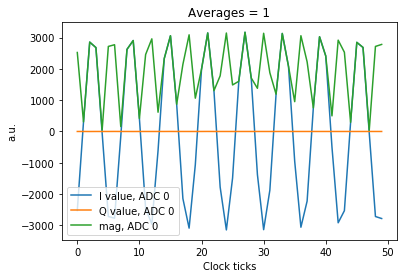

In [7]:
# Plot results.
plt.figure(1)
iq = iq_list[0]
plt.plot(iq[0], label="I value, ADC %d"%(config['ro_ch']))
plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_ch']))
plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))

print(sum(iq[0]), sum(iq[1]))

plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

In [8]:
iq_list = prog.acquire(soc, load_pulses=True, progress=True, debug=False)
# print(prog)
results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,127)]
print("I and Q values read from tproc input:", results)

print("I and Q values in accumulated buffer:", [iq*config['readout_length'] for iq in iq_list])


  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [2495, 3, 2495, 3]
I and Q values in accumulated buffer: [array([[2495.]]), array([[3.]])]


Above data was taken w/ the following setup: generated pulse is scaled w/ variable volgate attenuator, followed by ZX47-40 power detector, a DC block, and divided down by ~1/4 using a voltage divider. The latter is strictly speaking not necessary since the insertion loss of the var attenuator is always sufficient. However, can't hurt to be safe, and the RC time constant helps smooth out the signal a little (but fortuitously doesn't limit the risetime, which is already rather slow because of the ZX47-40 -- hence the readout is windowed on the second half of the pulse).

There's still some slow settling time, but that should not be of any consequence for what we're trying to do here.

# use read to transfer the ADC value to a register block register. 